In [1]:
# this code is based on [https://github.com/dome272/Diffusion-Models-pytorch], which is released under the Apache license
!pip install lpips
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10, STL10
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torchvision
from torch import optim
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import uuid
import time
import logging
from PIL import Image
import random

In [2]:
# Speed up training time
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.backends.cudnn.benchmark = True

In [3]:
DATASET = "CIFAR10"
BATCH_SIZE = 14
UNIQUE_RUN_ID = str(uuid.uuid4())
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = 32
NUM_CLASSES = 10
NUM_EPOCHS = 300
OPTIMIZER_LR = 3e-4

In [4]:
# optional for Colab use only - Google drive integration - this will allow you to save and resume training, and may speed up redownloading the dataset (FROM TEMPLATE)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Diffusion Tools
class Diffusion:
  def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=IMAGE_SIZE, device="cuda"):
    self.noise_steps = noise_steps
    self.beta_start = beta_start
    self.beta_end = beta_end
    self.img_size = img_size
    self.device = device

    self.beta = self.prepare_noise_schedule().to(device)
    self.alpha = 1. - self.beta
    self.alpha_hat = torch.cumprod(self.alpha, dim=0)
  
  def prepare_noise_schedule(self):
    return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)
  
  def noise_images(self, x, t):
    sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
    Ɛ = torch.randn_like(x)
    return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ
  
  def sample_timesteps(self, n):
    return torch.randint(low=1, high=self.noise_steps, size=(n,))
  
  # Follows Algorithm 2
  def sample(self, model, n, labels, cfg_scale=3):
    logging.info(f"Sampling {n} new images....")
    model.eval()
    with torch.no_grad():
      x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
      for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
        t = (torch.ones(n) * i).long().to(self.device)
        predicted_noise = model(x, t, labels)
        if cfg_scale > 0:
          uncond_predicted_noise = model(x, t, None)
          predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
        alpha = self.alpha[t][:, None, None, None]
        alpha_hat = self.alpha_hat[t][:, None, None, None]
        beta = self.beta[t][:, None, None, None]
        if i > 1:
          noise = torch.randn_like(x)
        else:
          noise = torch.zeros_like(x)
        x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
    model.train()
    x = (x.clamp(-1, 1) + 1) / 2
    x = (x * 255).type(torch.uint8)
    return x
  
  # Uses ammended version of algorithm 2 to generate interpolants at each timestep
  def sampleInterpolants(self, model, n, labels, cfg_scale=3, x=None):
    logging.info(f"Sampling {n} new images....")
    model.eval()
    with torch.no_grad():
      if x == None:
        x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
      for i in tqdm(reversed(range(1, self.noise_steps)), position=0):       
        t = (torch.ones(n) * i).long().to(self.device)

        x0 = x[0:col_size].repeat(col_size,1,1,1) 
        x1 = x[batch_size-col_size:].repeat(col_size,1,1,1) 
        lambda_ = torch.linspace(0,1,10).unsqueeze(1).repeat(1,10).view(100,1,1,1).to(device)
        x = (1-lambda_)*x0 + lambda_*x1

        z0 = model.encode(x0, t, y)
        z1 = model.encode(x1, t, y)
        predicted_noise = self.interpolateInLatentSpace(z0, z1, model, n, labels, t)

        if cfg_scale > 0:
          z0 = model.encode(x0, t, y)
          z1 = model.encode(x1, t, y)
          uncond_predicted_noise = self.interpolateInLatentSpace(z0, z1, model, n, None, t)

          predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
        alpha = self.alpha[t][:, None, None, None]
        alpha_hat = self.alpha_hat[t][:, None, None, None]
        beta = self.beta[t][:, None, None, None]
        if i > 1:
          noise = torch.randn_like(x)
        else:
          noise = torch.zeros_like(x)
        x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
    model.train()
    
    x = (x.clamp(-1, 1) + 1) / 2
    x = (x * 255).type(torch.uint8)
    return x

  def interpolateInLatentSpace(self, z0, z1, model, n, labels, t):
    lambda_ = torch.linspace(0,1,10).unsqueeze(1).repeat(1,10).view(100,1,1,1).to(device)

    lerp_z = []
    for i in range(len(z0)):
      lerp_z.append((1-lambda_)*z0[i] + lambda_*z1[i])
    
    # Decode once we have interpolated in latent space
    lerp_x = model.decode(lerp_z[0],lerp_z[1],lerp_z[2],lerp_z[3], t, labels)
    return lerp_x


In [6]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
    super().__init__()
    self.residual = residual
    if not mid_channels:
      mid_channels = out_channels
    self.double_conv = nn.Sequential(
      nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
      nn.GroupNorm(1, mid_channels),
      nn.GELU(),
      nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
      nn.GroupNorm(1, out_channels),
    )

  def forward(self, x):
    if self.residual:
      return F.gelu(x + self.double_conv(x))
    else:
      return self.double_conv(x)

In [7]:
class Down(nn.Module):
  def __init__(self, in_channels, out_channels, emb_dim=256):
    super().__init__()
    self.maxpool_conv = nn.Sequential(
      nn.MaxPool2d(2),
      DoubleConv(in_channels, in_channels, residual=True),
      DoubleConv(in_channels, out_channels),
    )

    self.emb_layer = nn.Sequential(
      nn.SiLU(),
      nn.Linear(
        emb_dim,
        out_channels
      ),
    )

  def forward(self, x, t):
    x = self.maxpool_conv(x)
    emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
    return x + emb

In [8]:
class Up(nn.Module):
  def __init__(self, in_channels, out_channels, emb_dim=256):
    super().__init__()

    self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
    self.conv = nn.Sequential(
      DoubleConv(in_channels, in_channels, residual=True),
      DoubleConv(in_channels, out_channels, in_channels // 2),
    )

    self.emb_layer = nn.Sequential(
        nn.SiLU(),
        nn.Linear(
          emb_dim,
          out_channels
        ),
    )

  def forward(self, x, skip_x, t):
    x = self.up(x)
    x = torch.cat([skip_x, x], dim=1)
    x = self.conv(x)
    emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
    return x + emb

In [9]:
class SelfAttention(nn.Module):
  def __init__(self, channels, size):
    super(SelfAttention, self).__init__()
    self.channels = channels
    self.size = size
    self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
    self.ln = nn.LayerNorm([channels])
    self.ff_self = nn.Sequential(
      nn.LayerNorm([channels]),
      nn.Linear(channels, channels),
      nn.GELU(),
      nn.Linear(channels, channels),
    )

  def forward(self, x):
    x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
    x_ln = self.ln(x)
    attention_value, _ = self.mha(x_ln, x_ln, x_ln)
    attention_value = attention_value + x
    attention_value = self.ff_self(attention_value) + attention_value
    return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)

In [10]:
class UNet_conditional_CIFAR(nn.Module):
  def __init__(self, c_in=3, c_out=3, time_dim=256, num_classes=10, device="cuda"):
    super().__init__()
    self.device = device
    self.time_dim = time_dim
    # Encoder
    self.inc = DoubleConv(c_in, 32)
    self.down1 = Down(32, 64)
    self.sa1 = SelfAttention(64, 16)
    self.down2 = Down(64, 128)
    self.sa2 = SelfAttention(128, 8)
    self.down3 = Down(128, 128)
    self.sa3 = SelfAttention(128, 4)

    # Bottleneck
    self.bot1 = DoubleConv(128, 256)
    self.bot2 = DoubleConv(256, 256)
    self.bot3 = DoubleConv(256, 128)

    # Decoder
    self.up1 = Up(256, 64)
    self.sa4 = SelfAttention(64, 8)
    self.up2 = Up(128, 32)
    self.sa5 = SelfAttention(32, 16)
    self.up3 = Up(64, 32)
    self.sa6 = SelfAttention(32, 32)
    self.outc = nn.Conv2d(32, c_out, kernel_size=1)

    if num_classes is not None:
      self.label_em = nn.Embedding(num_classes, time_dim)

  def pos_encoding(self, t, channels):
    inv_freq = 1.0 / (
      10000
      ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
    )
    pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
    pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
    pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
    return pos_enc

  def forward(self, x, t, y):
    t = t.unsqueeze(-1).type(torch.float)
    t = self.pos_encoding(t, self.time_dim)

    if y is not None:
      t += self.label_em(y)

    x1 = self.inc(x)
    x2 = self.down1(x1, t)
    x2 = self.sa1(x2)
    x3 = self.down2(x2, t)
    x3 = self.sa2(x3)
    x4 = self.down3(x3, t)
    x4 = self.sa3(x4)

    x4 = self.bot1(x4)
    x4 = self.bot2(x4)
    x4 = self.bot3(x4)

    x = self.up1(x4, x3, t)
    x = self.sa4(x)
    x = self.up2(x, x2, t)
    x = self.sa5(x)
    x = self.up3(x, x1, t)
    x = self.sa6(x)
    output = self.outc(x)
    return output
    
  # Seperate encode/decode functions for interpolating in latent space
  def encode(self, x, t, y):
    t = t.unsqueeze(-1).type(torch.float)
    t = self.pos_encoding(t, self.time_dim)

    if y is not None:
      t += self.label_em(y)

    x1 = self.inc(x)
    x2 = self.down1(x1, t)
    x2 = self.sa1(x2)
    x3 = self.down2(x2, t)
    x3 = self.sa2(x3)
    x4 = self.down3(x3, t)
    x4 = self.sa3(x4)
    x4 = self.bot1(x4)
    x4 = self.bot2(x4)
    x4 = self.bot3(x4)
    return [x1, x2, x3, x4]
  
  def decode(self, x1, x2, x3, x4, t, y):
    t = t.unsqueeze(-1).type(torch.float)
    t = self.pos_encoding(t, self.time_dim)

    if y is not None:
      t += self.label_em(y)
    
    x = self.up1(x4, x3, t)
    x = self.sa4(x)
    x = self.up2(x, x2, t)
    x = self.sa5(x)
    x = self.up3(x, x1, t)
    x = self.sa6(x)
    output = self.outc(x)
    return output

In [11]:
# Helper functions for getting and displaying dataset

def plot_images(images):
  plt.figure(figsize=(32, 32))
  plt.imshow(torch.cat([
    torch.cat([i for i in images.cpu()], dim=-1),
  ], dim=-2).permute(1, 2, 0).cpu())
  plt.show()


def save_images(images, path, **kwargs):
  grid = torchvision.utils.make_grid(images, **kwargs)
  ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
  im = Image.fromarray(ndarr)
  im.save(path)


def get_data():
  if DATASET == "CIFAR10":
    dataset = CIFAR10(os.getcwd(), download=True, train=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(32),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      ]))
  
  if DATASET == "STL10":
    dataset = STL10(os.getcwd(), download=True, split='train', transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(32),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      ]))
  
  dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
  return dataloader

def setup_logging(run_name):
  os.makedirs("./drive/MyDrive/models", exist_ok=True)
  os.makedirs("./drive/MyDrive/results", exist_ok=True)
  os.makedirs(os.path.join("./drive/MyDrive/models", UNIQUE_RUN_ID), exist_ok=True)
  os.makedirs(os.path.join("./drive/MyDrive/results", UNIQUE_RUN_ID), exist_ok=True)

def flatten(l):
    return [item for sublist in l for item in sublist]


In [12]:
def train(previousRunID=None, model=None, optimizer=None, startEpoch=0):
  device = DEVICE
  dataloader = get_data() 
  l = len(dataloader)

  if model == None: model = UNet_conditional_CIFAR(num_classes=NUM_CLASSES).to(device)
  if optimizer == None: optimizer = optim.AdamW(model.parameters(), lr=OPTIMIZER_LR)
  if previousRunID == None: 
    previousRunID = UNIQUE_RUN_ID
    setup_logging(UNIQUE_RUN_ID)

  mse = nn.MSELoss()
  diffusion = Diffusion(img_size=IMAGE_SIZE, device=device)
  logger = SummaryWriter(os.path.join("runs", previousRunID))
  
  for epoch in range(startEpoch, NUM_EPOCHS):
    logging.info(f"Starting epoch {epoch}:")
    pbar = tqdm(dataloader)
    # Algorithm 1
    for i, (images, labels) in enumerate(pbar):
      images = images.to(device)
      labels = labels.to(device)
      t = diffusion.sample_timesteps(images.shape[0]).to(device)
      x_t, noise = diffusion.noise_images(images, t)
      if np.random.random() < 0.1:
        labels = None
      predicted_noise = model(x_t, t, labels)
      loss = mse(noise, predicted_noise)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      pbar.set_postfix(MSE=loss.item())
      logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)

    if epoch % 10 == 0:
      labels = torch.arange(10).long().to(device)
      sampled_images = diffusion.sample(model, n=len(labels), labels=labels)
      save_images(sampled_images, os.path.join("./drive/MyDrive/results", previousRunID, f"{epoch}.jpg"))
      torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss,
              }, f"./drive/MyDrive/models/{previousRunID}/model{epoch}.pt")

In [13]:
'''
t0 = time.time()
train()
diff = time.time() - t0
print(diff)
'''

'\nt0 = time.time()\ntrain()\ndiff = time.time() - t0\nprint(diff)\n'

In [14]:
# An example of resuming training from some point
# Note this won't work since the loaded model is not included in submission
'''
t0 = time.time()
device = DEVICE
model = UNet_conditional_CIFAR(num_classes=NUM_CLASSES).to(device)
optimizer = optim.AdamW(model.parameters(), lr=OPTIMIZER_LR)

checkpoint = torch.load(f"./drive/MyDrive/models/a9585f5e-ae8a-4da2-9c50-9f39193de281/model185.pt")
model.load_state_dict(checkpoint['model_state_dict'])
model.train()
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
epoch += 1

resumeTraining('a9585f5e-ae8a-4da2-9c50-9f39193de281', model, optimizer, epoch)
diff = time.time() - t0
print(diff)
'''

'\nt0 = time.time()\ndevice = DEVICE\nmodel = UNet_conditional_CIFAR(num_classes=NUM_CLASSES).to(device)\noptimizer = optim.AdamW(model.parameters(), lr=OPTIMIZER_LR)\n\ncheckpoint = torch.load(f"./drive/MyDrive/models/a9585f5e-ae8a-4da2-9c50-9f39193de281/model185.pt")\nmodel.load_state_dict(checkpoint[\'model_state_dict\'])\nmodel.train()\noptimizer.load_state_dict(checkpoint[\'optimizer_state_dict\'])\nepoch = checkpoint[\'epoch\']\nepoch += 1\n\nresumeTraining(\'a9585f5e-ae8a-4da2-9c50-9f39193de281\', model, optimizer, epoch)\ndiff = time.time() - t0\nprint(diff)\n'

In [15]:
# Load in the model for image generation
# NOTE: this will not work in submission, as saved model states are not included.
#'''
device = "cuda"
model = UNet_conditional_CIFAR(num_classes=10).to(device)
checkpoint = torch.load(f"./drive/MyDrive/models/03db1355-d654-4cc4-b961-7b059bf0604d/model295.pt", map_location=torch.device(device))
model.load_state_dict(checkpoint['model_state_dict'])
diffusion = Diffusion(img_size=32, device=device)
#'''

999it [03:13,  5.15it/s]


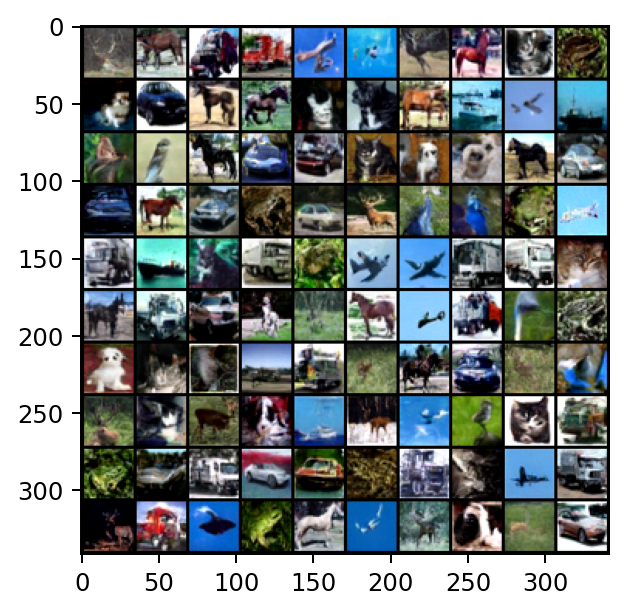

In [16]:
# Generate random set of images
n = 10
randomClasses = []
for i in range(n*n):
  randomClasses.append(random.randint(0,9))

items = randomClasses
y = torch.Tensor(items).long().to(DEVICE)
x0 = diffusion.sample(model, n*n, y, cfg_scale=3)

plt.rcParams['figure.dpi'] = 175
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(x0, nrow=10).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
#plt.savefig("samples.png")
plt.show()

In [25]:
# Check how similar nearest neighbours in training set are
# This code block relies on the code above supplying it with input x0
from sklearn.neighbors import NearestNeighbors, KDTree
import gc
import lpips
gc.collect()

trainData = CIFAR10(os.getcwd(), download=True, train=True).data
xN = torch.split(x0, 1)
loss_fn_alex = lpips.LPIPS(net='alex')

for i in range(len(xN)):
  x1 = xN[i].cpu().numpy()
  x1 = np.moveaxis(x1, [1], [3])

  # Get the nearest neighbour of the generated image from the train set
  trainSetAndCurrentSample = np.append(trainData, x1, 0)
  trainSetAndCurrentSample = trainSetAndCurrentSample.flatten().reshape(50001, 3072)

  nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(trainSetAndCurrentSample)
  result = nbrs.kneighbors(X=[trainAndSamples[-1]], n_neighbors=2, return_distance=False)
  nbrIndex = result[0][1]

  nbr = trainSetAndCurrentSample[nbrIndex]
  nbr = nbr.reshape(3, 32, 32)
  nbr = np.expand_dims(nbr, axis=0)
  nbr = torch.from_numpy(nbr)

  sample = trainSetAndCurrentSample[-1]
  sample = sample.reshape(3, 32, 32)
  sample = np.expand_dims(sample, axis=0)
  sample = torch.from_numpy(sample)

  # Get the similarity score of the two images
  d = loss_fn_alex(sample, nbr)
  print(d)



  




KeyboardInterrupt: ignored

In [ ]:
# now show some interpolations (note you do not have to do linear interpolations as shown here, you can do non-linear or gradient-based interpolation if you wish)
batch_size = 100
diffusion = Diffusion(img_size=32, device=DEVICE)
col_size = int(np.sqrt(batch_size))

items = flatten([range(col_size)] * col_size)
y = torch.Tensor(items).long().to(DEVICE)

lerp_g = diffusion.sampleInterpolants(model, 100, y, cfg_scale=0) 

plt.rcParams['figure.dpi'] = 175
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(lerp_g, nrow=10).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
#plt.savefig("interpolants2.png")
plt.show()